In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
pip install chardet

In [ ]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [ ]:
# Load tokenizer and pre-trained model
tokenizer = AutoTokenizer.from_pretrained("lakshyakh93/deberta_finetuned_pii")
model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.31k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/555M [00:00<?, ?B/s]

In [ ]:
# # Load the mini dataset (200 row)
# import chardet

# filepath = os.path.join(os.getcwd(), 'mini_df_200_row_biolabels.csv')

# # Detect encoding
# with open(filepath, 'rb') as f:
#     result = chardet.detect(f.read())
#     print("Detected file encoding:", result['encoding'])

# # Read the file using the detected encoding
# mini_df = pd.read_csv(filepath, encoding=result['encoding'])

# # Proportional split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Since you have 200 rows, no need for the 3,000 cap, as this won't be needed
# train_size = int(len(mini_df) * train_ratio)
# val_size = int(len(mini_df) * val_ratio)
# test_size = len(mini_df) - train_size - val_size  # Remaining rows for the test set

# # Split the dataset into train, validation, and test sets
# train_df, temp_df = train_test_split(mini_df, test_size=1 - train_ratio, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

# # Print dataset sizes to confirm
# print(f"Training size: {len(train_df)}")
# print(f"Validation size: {len(val_df)}")
# print(f"Test size: {len(test_df)}")

In [ ]:
# # For the cleaned mini dataframe
# # Create a mapping for the bio_labels
# data_label_list = []

# # Extract unique labels from the 'bio_labels' column
# def get_unique_labels(df):
#     unique_labels = set()
#     for labels in df['bio_labels']:  # Iterate through the 'bio_labels' column
#         # Since bio_labels is a string representation of a list, we need to convert it back to a list
#         labels = eval(labels)  # Convert the string to a list
#         unique_labels.update(labels)  # Add all labels in the current row to the set
#     return sorted(unique_labels)  # Return sorted labels for consistency

# # Apply the function to the entire DataFrame
# unique_labels = get_unique_labels(mini_df)  # Run on the whole DataFrame

# # Print the unique labels
# print("Data's Unique BIO Labels:", unique_labels)

# # Combine with the existing label_list (if applicable)
# data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
# print("Data's Final Label List:", data_label_list)
# print(len(data_label_list))  # Number of unique labels

# data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
# data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

In [ ]:
# Calculate the proportional sizes
total_samples = 8000
train_ratio = 7
val_ratio = 1.5
test_ratio = 1.5

total_ratio = train_ratio + val_ratio + test_ratio

train_size = int(total_samples * (train_ratio / total_ratio))
val_size = int(total_samples * (val_ratio / total_ratio))
test_size = total_samples - train_size - val_size

# Load dataset
dataset = load_dataset("Isotonic/pii-masking-200k")

# First, split off the test and validation sets
first_split = dataset["train"].train_test_split(test_size=(val_size + test_size)/len(dataset["train"]), seed=42)

# Then split the remaining data into train
train_split = first_split["train"].shuffle(seed=42).select(range(train_size))
val_test_split = first_split["test"].shuffle(seed=42).select(range(val_size + test_size))
val_split = val_test_split.select(range(val_size))
test_split = val_test_split.select(range(val_size, val_size + test_size))

# Create the final DatasetDict
dataset_splits = DatasetDict({
    "train": train_split,
    "validation": val_split,
    "test": test_split
})

print(f"Training size: {len(dataset_splits['train'])}")
print(f"Validation size: {len(dataset_splits['validation'])}")
print(f"Test size: {len(dataset_splits['test'])}")

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

(…)-00000-of-00001-71c6cfc74148fe46.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/209261 [00:00<?, ? examples/s]

Training size: 5600
Validation size: 1200
Test size: 1200


In [ ]:
# Convert test_dataset into a dataframe
pii200k_train = dataset_splits['train'].to_pandas()
pii200k_val = dataset_splits['test'].to_pandas()
pii200k_test = dataset_splits['test'].to_pandas()

eng_train = pii200k_train[pii200k_train['language'] == 'en']
eng_val = pii200k_val[pii200k_val['language'] == 'en']
eng_test = pii200k_test[pii200k_test['language'] == 'en']

print(len(eng_train))
print(len(eng_val))
print(len(eng_test))

1156
249
249


In [ ]:
# Filter rows where 'bio_labels' is not null (though unlikely given your data)
valid_eng_train = eng_train[eng_train['bio_labels'].notnull()]
valid_eng_val = eng_val[eng_val['bio_labels'].notnull()]
valid_eng_test = eng_test[eng_test['bio_labels'].notnull()]

import numpy as np
import re

def clean_bio_labels(bio_labels):
    # Flatten the numpy array of bio_labels and remove any non-printable characters
    bio_labels = [label for label in bio_labels.flatten() if isinstance(label, str)]
    cleaned_labels = [re.sub(r'[^\x20-\x7E]', '', label) for label in bio_labels]
    return cleaned_labels

# Apply the cleaning function to each bio_labels entry
eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
eng_test['bio_labels'] = eng_test['bio_labels'].apply(clean_bio_labels)

# Check the resulting DataFrame
print(f"Number of valid rows in eng_train: {len(eng_train)}")
print(f"Number of valid rows in eng_val: {len(eng_val)}")
print(f"Number of valid rows in eng_test: {len(eng_test)}")

Number of valid rows in eng_train: 1156
Number of valid rows in eng_val: 249
Number of valid rows in eng_test: 249


<ipython-input-9-a54fa4498df2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
<ipython-input-9-a54fa4498df2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
<ipython-input-9-a54fa4498df2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [ ]:
data_label_list = []

# Extract unique BIO labels
unique_labels = set()

# Iterate through the 'bio_labels' column
for labels in eng_train['bio_labels']:
    unique_labels.update(labels)  # Add all unique labels from each array

# Convert to sorted list for consistency
unique_labels = sorted(unique_labels)

print("Data's Unique BIO Labels:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Combine with the existing label_list (if applicable)
data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
print("Data's Final Label List:", data_label_list)
print(len(data_label_list))  # Number of unique labels

data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

Data's Unique BIO Labels: ['B-ACCOUNTNAME', 'B-ACCOUNTNUMBER', 'B-AGE', 'B-AMOUNT', 'B-BIC', 'B-BITCOINADDRESS', 'B-BUILDINGNUMBER', 'B-CITY', 'B-COMPANYNAME', 'B-COUNTY', 'B-CREDITCARDCVV', 'B-CREDITCARDISSUER', 'B-CREDITCARDNUMBER', 'B-CURRENCY', 'B-CURRENCYCODE', 'B-CURRENCYNAME', 'B-CURRENCYSYMBOL', 'B-DATE', 'B-DOB', 'B-EMAIL', 'B-ETHEREUMADDRESS', 'B-EYECOLOR', 'B-FIRSTNAME', 'B-GENDER', 'B-HEIGHT', 'B-IBAN', 'B-IP', 'B-IPV4', 'B-IPV6', 'B-JOBAREA', 'B-JOBTITLE', 'B-JOBTYPE', 'B-LASTNAME', 'B-LITECOINADDRESS', 'B-MAC', 'B-MASKEDNUMBER', 'B-MIDDLENAME', 'B-NEARBYGPSCOORDINATE', 'B-ORDINALDIRECTION', 'B-PASSWORD', 'B-PHONEIMEI', 'B-PHONENUMBER', 'B-PIN', 'B-PREFIX', 'B-SECONDARYADDRESS', 'B-SEX', 'B-SSN', 'B-STATE', 'B-STREET', 'B-TIME', 'B-URL', 'B-USERAGENT', 'B-USERNAME', 'B-VEHICLEVIN', 'B-VEHICLEVRM', 'B-ZIPCODE', 'I-ACCOUNTNAME', 'I-ACCOUNTNUMBER', 'I-AGE', 'I-AMOUNT', 'I-BIC', 'I-BITCOINADDRESS', 'I-BUILDINGNUMBER', 'I-CITY', 'I-COMPANYNAME', 'I-COUNTY', 'I-CREDITCARDISSUER'

In [ ]:
model_label_list = model.config.id2label.values()  # Ensure this matches the fine-tuned model
model_id_to_label = {int(k): v for k, v in model.config.id2label.items()}
model_label_to_id = {v: int(k) for k, v in model_id_to_label.items()}

print("Model's Label to ID:", model_label_to_id)
print("Model's ID to Label:", model_id_to_label)
print(len(model_label_list))

Model's Label to ID: {'B-PREFIX': 0, 'I-PREFIX': 1, 'B-FIRSTNAME': 2, 'I-FIRSTNAME': 3, 'B-MIDDLENAME': 4, 'B-LASTNAME': 5, 'I-LASTNAME': 6, 'O': 7, 'B-JOBDESCRIPTOR': 8, 'B-JOBTITLE': 9, 'I-JOBTITLE': 10, 'B-COMPANY_NAME': 11, 'I-COMPANY_NAME': 12, 'B-JOBAREA': 13, 'B-EMAIL': 14, 'I-EMAIL': 15, 'B-TIME': 16, 'I-TIME': 17, 'B-DATE': 18, 'I-DATE': 19, 'B-URL': 20, 'I-URL': 21, 'B-BITCOINADDRESS': 22, 'I-BITCOINADDRESS': 23, 'B-ETHEREUMADDRESS': 24, 'I-ETHEREUMADDRESS': 25, 'B-ACCOUNTNAME': 26, 'I-ACCOUNTNAME': 27, 'B-IBAN': 28, 'I-IBAN': 29, 'B-ACCOUNTNUMBER': 30, 'I-ACCOUNTNUMBER': 31, 'B-BIC': 32, 'I-BIC': 33, 'B-IPV4': 34, 'I-IPV4': 35, 'B-STREETADDRESS': 36, 'I-STREETADDRESS': 37, 'B-CITY': 38, 'I-CITY': 39, 'B-ZIPCODE': 40, 'I-ZIPCODE': 41, 'B-USERNAME': 42, 'I-USERNAME': 43, 'B-IPV6': 44, 'I-IPV6': 45, 'B-CREDITCARDNUMBER': 46, 'I-CREDITCARDNUMBER': 47, 'B-VEHICLEVIN': 48, 'I-VEHICLEVIN': 49, 'B-SUFFIX': 50, 'I-SUFFIX': 51, 'B-AMOUNT': 52, 'I-AMOUNT': 53, 'B-CURRENCY': 54, 'I-CURR

In [ ]:
# Define metrics calculation function
def compute_metrics(predictions, references):
    acc = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average="weighted", zero_division=1)
    recall = recall_score(references, predictions, average="weighted", zero_division=1)
    f1 = f1_score(references, predictions, average="weighted", zero_division=1)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import numpy as np

def tokenize_and_align_labels(df, tokenizer, data_label_to_id, model_label_to_id):
    def normalize_label(label):
        # Remove suffixes like "_1", "_2"
        if "_" in label and label.split("_")[-1].isdigit():
            return "_".join(label.split("_")[:-1])
        return label

    def map_labels_to_model(data_label):
        normalized_label = normalize_label(data_label)  # Normalize dataset labels
        return model_label_to_id.get(normalized_label, model_label_to_id.get("O", -100))  # Default to "O"

    # Tokenize input text
    tokenized_inputs = tokenizer(
        list(df["unmasked_text"]),  # Convert Series to list of strings
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
        is_split_into_words=False,
    )

    labels = []
    for i, label_seq in enumerate(df["bio_labels"]):
        word_labels = eval(label_seq) if isinstance(label_seq, str) else label_seq  # Convert string back to list if needed
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens back to words
        token_labels = []
        for word_id in word_ids:
            if word_id is None:  # Special tokens
                token_labels.append(-100)
            elif word_id < len(word_labels):  # Ensure within bounds
                token_labels.append(map_labels_to_model(word_labels[word_id]))
            else:
                token_labels.append(-100)  # Ignore out-of-bounds tokens
        labels.append(token_labels)

    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Tokenize the training set
tokenized_train = tokenize_and_align_labels(eng_train, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the training set
train_dataset = torch.utils.data.TensorDataset(tokenized_train["input_ids"], tokenized_train["attention_mask"], tokenized_train["labels"])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Tokenize the validation set
tokenized_val = tokenize_and_align_labels(eng_val, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the validation set
val_dataset = torch.utils.data.TensorDataset(tokenized_val["input_ids"], tokenized_val["attention_mask"], tokenized_val["labels"])
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Tokenize the test set
tokenized_test = tokenize_and_align_labels(eng_test, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the test set
test_dataset = torch.utils.data.TensorDataset(tokenized_test["input_ids"], tokenized_test["attention_mask"], tokenized_test["labels"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for key, value in tokenized_train.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_val.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_test.items():
    print(f"{key}: {value.shape}")

input_ids: torch.Size([1156, 138])
token_type_ids: torch.Size([1156, 138])
attention_mask: torch.Size([1156, 138])
labels: torch.Size([1156, 138])
input_ids: torch.Size([249, 137])
token_type_ids: torch.Size([249, 137])
attention_mask: torch.Size([249, 137])
labels: torch.Size([249, 137])
input_ids: torch.Size([249, 137])
token_type_ids: torch.Size([249, 137])
attention_mask: torch.Size([249, 137])
labels: torch.Size([249, 137])


In [ ]:
id_to_label = {v: k for k, v in model_label_to_id.items()}

In [ ]:
# # Find the optimized hyperparameters

# import optuna

# def objective(trial):
#     # Suggest hyperparameters
#     batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
#     temperature = trial.suggest_float("temperature", 0.5, 2.0)
#     use_fp16 = trial.suggest_categorical("use_fp16", [True, False])

#     # Configure inference settings
#     all_predictions, all_references = [], []
#     model.eval()

#     with torch.no_grad():
#         for batch in test_dataloader:
#             input_ids, attention_mask, labels = [t.to(device) for t in batch]

#             # Mixed precision inference
#             with torch.cuda.amp.autocast(enabled=use_fp16):
#                 outputs = model(input_ids, attention_mask=attention_mask)
#                 logits = outputs.logits / temperature  # Apply temperature scaling

#             # Get predictions
#             predictions = torch.argmax(logits, dim=-1).cpu().numpy()
#             labels = labels.cpu().numpy()

#             # Align predictions and references to only include non-special tokens
#             for pred, label in zip(predictions, labels):
#                 true_labels = [id_to_label[l] for l in label if l != -100]
#                 pred_labels = [
#                     id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
#                 ]
#                 all_predictions.extend(pred_labels)
#                 all_references.extend(true_labels)

#     # Calculate metrics
#     metrics = compute_metrics(all_predictions, all_references)
#     return metrics["f1"]  # Optimize for F1 score

# # Hyperparameter optimization with Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# # Display the best hyperparameters
# print("Best hyperparameters:", study.best_params)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from torch.cuda.amp import GradScaler, autocast

# Initialize lists to store loss and metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_metric = float('-inf')  # Initialize best metric as negative infinity
epochs_without_improvement = 0  # Counter for no improvement

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Define optimizer and scheduler
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 10
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps)

# Training and validation loop
model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    step = 0

    # Training loop
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        with autocast():  # Updated autocast usage
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        if step % 10 == 0:  # Log every 10 steps
            avg_loss = total_loss / (step + 1)
            print(f"Step {step}/{len(train_dataloader)}, Loss: {loss.item()}, Avg Loss: {avg_loss}")

        step += 1

    # Calculate average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_predictions, all_references = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Process predictions and references
            for pred, label in zip(predictions, labels):
                true_labels = [id_to_label[l] for l in label if l != -100]
                pred_labels = [id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100]
                all_predictions.extend(pred_labels)
                all_references.extend(true_labels)

    # Compute validation metrics
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    metrics = compute_metrics(all_predictions, all_references)
    print(f"Validation Metrics: {metrics}")
    val_accuracies.append(metrics['accuracy'])
    val_precisions.append(metrics['precision'])
    val_recalls.append(metrics['recall'])
    val_f1_scores.append(metrics['f1'])

    print(f"Validation Metrics: {metrics}")
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss}")
    # Early stopping logic
    val_metric = metrics['f1']  # Use F1 score as the metric to monitor
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        epochs_without_improvement = 0
        print("Validation F1 improved. Saving model...")
        torch.save(model.state_dict(), "best_deberta.pth")  # Save best model
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    model.train()  # Return to training mode

<ipython-input-19-90cb11e60b5c>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage



Epoch 1/10
Step 0/37, Loss: 0.45357826352119446, Avg Loss: 0.45357826352119446
Step 10/37, Loss: 0.4423057436943054, Avg Loss: 0.436140775680542
Step 20/37, Loss: 0.4502192437648773, Avg Loss: 0.4330479275612604
Step 30/37, Loss: 0.4138173460960388, Avg Loss: 0.43343299146621456
Epoch 1 Training Loss: 0.43329515006091146


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7880138232084394, 'precision': 0.7883309113794391, 'recall': 0.7880138232084394, 'f1': 0.7810241085243296}
Validation Metrics: {'accuracy': 0.7880138232084394, 'precision': 0.7883309113794391, 'recall': 0.7880138232084394, 'f1': 0.7810241085243296}
Epoch 1 Validation Loss: 0.6680057868361473
Validation F1 improved. Saving model...

Epoch 2/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.4473135769367218, Avg Loss: 0.4473135769367218
Step 10/37, Loss: 0.3852601647377014, Avg Loss: 0.3872354680841619
Step 20/37, Loss: 0.3787802755832672, Avg Loss: 0.38003285725911456
Step 30/37, Loss: 0.36708420515060425, Avg Loss: 0.38455245379478703
Epoch 2 Training Loss: 0.3838791166608398


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.785376500545653, 'precision': 0.7957055946527294, 'recall': 0.785376500545653, 'f1': 0.7807480936849355}
Validation Metrics: {'accuracy': 0.785376500545653, 'precision': 0.7957055946527294, 'recall': 0.785376500545653, 'f1': 0.7807480936849355}
Epoch 2 Validation Loss: 0.6933178156614304
No improvement for 1 epoch(s).

Epoch 3/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.392205148935318, Avg Loss: 0.392205148935318
Step 10/37, Loss: 0.355582594871521, Avg Loss: 0.34549402648752386
Step 20/37, Loss: 0.34126076102256775, Avg Loss: 0.343646438348861
Step 30/37, Loss: 0.33828526735305786, Avg Loss: 0.34630519536233717
Epoch 3 Training Loss: 0.3462521812400302


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7986540560203711, 'precision': 0.794705475993776, 'recall': 0.7986540560203711, 'f1': 0.7890536324033937}
Validation Metrics: {'accuracy': 0.7986540560203711, 'precision': 0.794705475993776, 'recall': 0.7986540560203711, 'f1': 0.7890536324033937}
Epoch 3 Validation Loss: 0.6719981729984283
Validation F1 improved. Saving model...

Epoch 4/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.3227158784866333, Avg Loss: 0.3227158784866333
Step 10/37, Loss: 0.3463047742843628, Avg Loss: 0.3141035329211842
Step 20/37, Loss: 0.31717512011528015, Avg Loss: 0.312543096996489
Step 30/37, Loss: 0.30773213505744934, Avg Loss: 0.31088725597627703
Epoch 4 Training Loss: 0.3117272841769296


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7988359403419425, 'precision': 0.7978303900056167, 'recall': 0.7988359403419425, 'f1': 0.7924967876859571}
Validation Metrics: {'accuracy': 0.7988359403419425, 'precision': 0.7978303900056167, 'recall': 0.7988359403419425, 'f1': 0.7924967876859571}
Epoch 4 Validation Loss: 0.6809296607971191
Validation F1 improved. Saving model...

Epoch 5/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.3168758451938629, Avg Loss: 0.3168758451938629
Step 10/37, Loss: 0.2959957718849182, Avg Loss: 0.2928877797993747
Step 20/37, Loss: 0.3017083406448364, Avg Loss: 0.2922677497069041
Step 30/37, Loss: 0.28318336606025696, Avg Loss: 0.2918794592542033
Epoch 5 Training Loss: 0.2917125450598227


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7982902873772281, 'precision': 0.8011293279492054, 'recall': 0.7982902873772281, 'f1': 0.7946805589124312}
Validation Metrics: {'accuracy': 0.7982902873772281, 'precision': 0.8011293279492054, 'recall': 0.7982902873772281, 'f1': 0.7946805589124312}
Epoch 5 Validation Loss: 0.6845215037465096
Validation F1 improved. Saving model...

Epoch 6/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.30248522758483887, Avg Loss: 0.30248522758483887
Step 10/37, Loss: 0.31659266352653503, Avg Loss: 0.27817421609705145
Step 20/37, Loss: 0.276431679725647, Avg Loss: 0.27623557334854487
Step 30/37, Loss: 0.27734795212745667, Avg Loss: 0.2766221050293215
Epoch 6 Training Loss: 0.2771283480766657


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7981084030556566, 'precision': 0.8066369728924465, 'recall': 0.7981084030556566, 'f1': 0.7972615837159207}
Validation Metrics: {'accuracy': 0.7981084030556566, 'precision': 0.8066369728924465, 'recall': 0.7981084030556566, 'f1': 0.7972615837159207}
Epoch 6 Validation Loss: 0.692510798573494
Validation F1 improved. Saving model...

Epoch 7/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.32203468680381775, Avg Loss: 0.32203468680381775
Step 10/37, Loss: 0.30513086915016174, Avg Loss: 0.2753904949535023
Step 20/37, Loss: 0.27626001834869385, Avg Loss: 0.2695769667625427
Step 30/37, Loss: 0.27850523591041565, Avg Loss: 0.2701174496643005
Epoch 7 Training Loss: 0.2702061578228667


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.8023826846125864, 'precision': 0.8001059478463496, 'recall': 0.8023826846125864, 'f1': 0.7968006517632128}
Validation Metrics: {'accuracy': 0.8023826846125864, 'precision': 0.8001059478463496, 'recall': 0.8023826846125864, 'f1': 0.7968006517632128}
Epoch 7 Validation Loss: 0.6732066944241524
No improvement for 1 epoch(s).

Epoch 8/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.27620062232017517, Avg Loss: 0.27620062232017517
Step 10/37, Loss: 0.28376713395118713, Avg Loss: 0.261857807636261
Step 20/37, Loss: 0.25011247396469116, Avg Loss: 0.255483288140524
Step 30/37, Loss: 0.28428658843040466, Avg Loss: 0.25711365717072643
Epoch 8 Training Loss: 0.25788979635045334


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7992906511458713, 'precision': 0.8045785862595911, 'recall': 0.7992906511458713, 'f1': 0.7972680099099935}
Validation Metrics: {'accuracy': 0.7992906511458713, 'precision': 0.8045785862595911, 'recall': 0.7992906511458713, 'f1': 0.7972680099099935}
Epoch 8 Validation Loss: 0.6985870078206062
Validation F1 improved. Saving model...

Epoch 9/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.264083594083786, Avg Loss: 0.264083594083786
Step 10/37, Loss: 0.28333693742752075, Avg Loss: 0.2515693550760096
Step 20/37, Loss: 0.2297784388065338, Avg Loss: 0.24684765934944153
Step 30/37, Loss: 0.2537369728088379, Avg Loss: 0.24887115147805983
Epoch 9 Training Loss: 0.25044569735591476


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7978355765732994, 'precision': 0.8031093069432533, 'recall': 0.7978355765732994, 'f1': 0.7960886619842799}
Validation Metrics: {'accuracy': 0.7978355765732994, 'precision': 0.8031093069432533, 'recall': 0.7978355765732994, 'f1': 0.7960886619842799}
Epoch 9 Validation Loss: 0.713076651096344
No improvement for 1 epoch(s).

Epoch 10/10


<ipython-input-19-90cb11e60b5c>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/37, Loss: 0.26450130343437195, Avg Loss: 0.26450130343437195
Step 10/37, Loss: 0.25840234756469727, Avg Loss: 0.24418467554179105
Step 20/37, Loss: 0.24715492129325867, Avg Loss: 0.2411856253941854
Step 30/37, Loss: 0.2593720555305481, Avg Loss: 0.2446345917640194
Epoch 10 Training Loss: 0.2457639814631359


<ipython-input-19-90cb11e60b5c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.8002000727537286, 'precision': 0.8044828280119611, 'recall': 0.8002000727537286, 'f1': 0.7975610528280974}
Validation Metrics: {'accuracy': 0.8002000727537286, 'precision': 0.8044828280119611, 'recall': 0.8002000727537286, 'f1': 0.7975610528280974}
Epoch 10 Validation Loss: 0.7035468593239784
Validation F1 improved. Saving model...


In [ ]:
from google.colab import files

# Download the saved model file
files.download("best_deberta.pth")

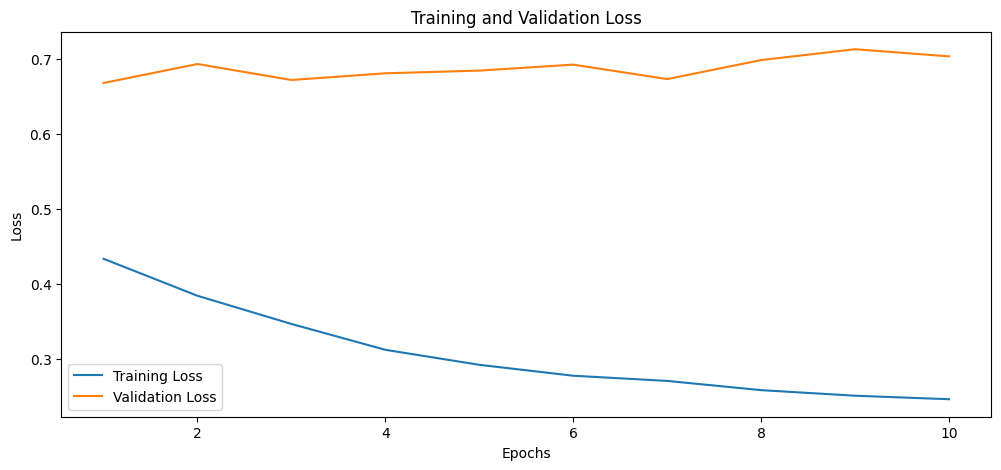

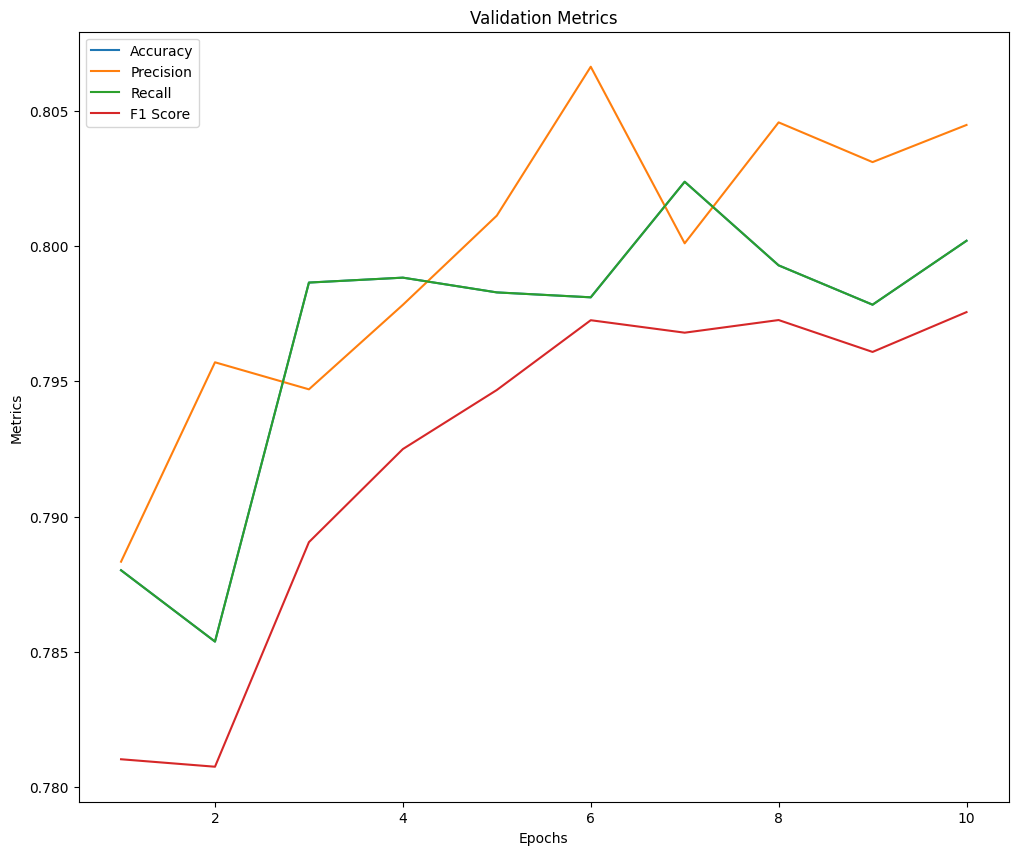

In [ ]:
# Visualization
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation metrics
plt.figure(figsize=(12, 10))
plt.plot(epochs, val_accuracies, label="Accuracy")
plt.plot(epochs, val_precisions, label="Precision")
plt.plot(epochs, val_recalls, label="Recall")
plt.plot(epochs, val_f1_scores, label="F1 Score")
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

In [ ]:
# Inference loop using the optimized hyperparameters
all_predictions, all_references = [], []
best_deberta.eval()

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits / 0.9989592666538125  # Use optimized temperature

        # Get predictions
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Align predictions and references to only include non-special tokens
        for pred, label in zip(predictions, labels):
            true_labels = [
                id_to_label[l] for l in label if l != -100
            ]  # Convert ground truth IDs to labels
            pred_labels = [
                id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
            ]  # Convert predictions to labels, defaulting to "O" for unmapped IDs

            all_predictions.extend(pred_labels)
            all_references.extend(true_labels)

# Calculate metrics
metrics = compute_metrics(all_predictions, all_references)
print("Test metrics:", metrics)

In [ ]:
print(f"all predictions: {all_predictions}")
print(f"number of all predictions: {len(all_predictions)}")
print(f"all references: {all_references}")
print(f"number of all references: {len(all_references)}")

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Extract the unique classes from all_references and all_predictions
unique_labels = sorted(set(all_references) | set(all_predictions))
display_labels = [id_to_label[label] for label in unique_labels]

# Plot the confusion matrix with consistent labels
ConfusionMatrixDisplay.from_predictions(
    all_references,
    all_predictions,
    display_labels=display_labels
)
plt.title("Confusion Matrix (Filtered Labels)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_references, all_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot F1 scores for each label
df["f1-score"].plot(kind="bar", figsize=(12, 6))
plt.title("F1 Score by Label")
plt.ylabel("F1 Score")
plt.xlabel("Labels")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np

cm = confusion_matrix(all_references, all_predictions)
misclassified_indices = np.unravel_index(np.argsort(-cm, axis=None), cm.shape)
top_misclassifications = [
    (id_to_label[misclassified_indices[0][i]], id_to_label[misclassified_indices[1][i]], cm[misclassified_indices[0][i], misclassified_indices[1][i]])
    for i in range(10)  # Top 10 misclassifications
]

for true, predicted, count in top_misclassifications:
    print(f"True: {true}, Predicted: {predicted}, Count: {count}")

# Extract unique indices for the top misclassifications
unique_indices = list(set([misclassified_indices[0][i] for i in range(10)] +
                          [misclassified_indices[1][i] for i in range(10)]))

# Create a subset confusion matrix
subset_cm = cm[np.ix_(unique_indices, unique_indices)]
subset_labels = [list(id_to_label.values())[i] for i in unique_indices]

# Plot the subset confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=subset_cm, display_labels=subset_labels)
disp.plot(cmap="viridis", xticks_rotation="vertical", colorbar=True)
plt.title("Confusion Matrix For Top Misclassifications)")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Convert string labels to numeric IDs using id_to_label reverse mapping
label_to_id_reverse = {label: idx for idx, label in id_to_label.items()}

# Map predictions and references to numeric IDs
numeric_predictions = [label_to_id_reverse[label] for label in all_predictions]
numeric_references = [label_to_id_reverse[label] for label in all_references]

# Choose the label ID of interest (e.g., for binary classification, the positive class)
pos_label_id = label_to_id_reverse["B-CREDITCARDNUMBER"]  # Replace "B-YOUR_LABEL" with your target class

# Compute precision-recall curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label=pos_label_id)

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Flatten predictions and references for multiclass handling (if applicable)
# Note: This works best for binary or one-vs-all analysis.
# Example below assumes binary or flattened labels.
precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label="B-CREDITCARDNUMBER")

# Display Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()
